In [4]:
# Basic Library
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

import numdifftools as nd
from scipy.optimize import minimize
from scipy.stats import entropy
import time

# Functions
def sigmoid(x): return 1 / (1 + np.exp(-x))
def softmax(x): return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
def bin_en(p): return np.nan_to_num( - p*np.log(p) - (1-p)*np.log(1-p) )
def normalize(belief): return belief / belief.sum()
def minmax(x):  return (x-np.min(x))/(np.max(x)-np.min(x))
def log_gaussian(x, mean, cov_inv):
    if np.array(x).ndim==1:  x = x.reshape(1,-1)
    return -(1/2) * np.sum((x - mean) @ (cov_inv) * (x - mean), axis=1)

# Models
def MIRT(ps, qs):
    ps_, qs_ = ps, qs
    if np.array(qs).ndim==1:  qs_ = [qs]
    if np.array(ps).ndim==1:  ps_ = [ps]
    r = np.prod(sigmoid(np.array([qs_] * len(ps_)) + np.array([ps_] * len(qs_)).swapaxes(0,1)), axis=2)
    return r

def LN(ps, qs):
    ps_, qs_ = ps, qs
    if np.array(qs).ndim==1:  qs_ = qs.reshape(1,-1)
    if np.array(ps).ndim==1:  ps_ = ps.reshape(1,-1)
    r = sigmoid(ps_@qs_.T[:-1] + qs_.T[1])
    return r

# Experiments
class Record():
    def __init__(self):
        self.typs = ['MAP', 'nHess', 'bins', 'belief', 'ent', 'f', 'true_f', 'time']
        self.data = { typ:[] for typ in self.typs }

    def merge(self, subRecord):
        for typ in self.typs:
            self.data[typ].append(subRecord.data[typ])

class Belief():
    """
    Class Representation of Bayesian Belief.
    """
    def __init__(self, f, dim, MAP_0, nHess_0, bins_0, n_bins):
        self.dim = dim # dimension
        self.f = f # set correct rate function

        self.MAP_0 = MAP_0
        self.nHess_0 = nHess_0
        self.bins_0 = bins_0
        self.n_bins = n_bins
                
        self.LPrior = lambda theta : log_gaussian(theta, mean=self.MAP_0, cov_inv=self.nHess_0)
        self.belief_0 = normalize(np.exp(self.LPrior(self.bins_0)))
        self.ent_0 = entropy(self.belief_0)
        
        self.par_0 = {'MAP_0' : self.MAP_0, 'nHess_0' : self.nHess_0, 'bins_0' : self.bins_0, 'belief_0' : self.belief_0, 'ent_0' : self.ent_0}
        self.initialize(self.MAP_0, self.nHess_0)
        

    def initialize(self, MAP_0, nHess_0): # clear history
        self.t, self.MAP, self.nHess, self.bins, self.belief, self.ent = 0, MAP_0, nHess_0, self.bins_0, self.belief_0, self.ent_0
        self.LL_t = [self.LPrior] # Log Likelihood at step t
        
        self.Record = Record()
        self.Record.data['MAP'].append(self.MAP)
        self.Record.data['nHess'].append(self.nHess)
        self.Record.data['bins'].append(self.bins)
        self.Record.data['belief'].append(self.belief)
        self.Record.data['ent'].append(self.ent)
    
    
    def bayesian_update(self, x, y):
        LL = lambda theta : np.log( self.f(theta, x).reshape(-1) if y==1 else 1-self.f(theta, x).reshape(-1) ) # Log Likelihood
        self.LL_t.append(LL)
        
        NLPosterior = lambda theta : -sum([self.LL_t[L_idx](theta) for L_idx in range(len(self.LL_t))])
        gradient = nd.Gradient(NLPosterior)
        hessian = nd.Hessian(NLPosterior)

        
        
        # Laplace Approximation
        self.MAP = self.bins[np.argmin(NLPosterior(self.bins))]
        self.nHess = hessian(self.MAP)
        self.bins = np.random.multivariate_normal(self.MAP, np.linalg.inv(self.nHess), self.n_bins)
        self.belief = normalize(np.exp(-NLPosterior(self.bins)))
        self.ent = entropy(self.belief)
        
        self.t += 1

        self.Record.data['MAP'].append(self.MAP)
        self.Record.data['nHess'].append(self.nHess)
        self.Record.data['bins'].append(self.bins)
        self.Record.data['belief'].append(self.belief)
        self.Record.data['ent'].append(self.ent)

class Experiment():
    def __init__(self, Algo, dim, f, num_t, MAP_0, nHess_0, bins_0, n_bins, R, P, Q, PQI):
        self.Algo = Algo
        self.dim = dim
        self.f = f
        self.num_t = num_t
        self.MAP_0 = MAP_0
        self.nHess_0 = nHess_0
        self.bins_0 = bins_0
        self.n_bins = n_bins
        
        self.R = R
        self.P = P
        self.Q = Q
        self.PQI = PQI
    
    def do(self, populate_idx) :
        Data = []
        for i in tqdm(populate_idx) :
            
            self.Belief = Belief(self.f, self.dim, self.MAP_0, self.nHess_0, self.bins_0, self.n_bins)
            
            if self.num_t < len(self.PQI[i]) :
                self.true_theta = self.P[i]
                
                self.Belief.initialize(self.MAP_0, self.nHess_0)
                while self.Belief.t < self.num_t:
                    start_time = time.time()
                    
                    # Query suggestion by Algorithm
                    idx = self.Algo.query(self.Belief, self.Q[self.PQI[i]])
                    self.Belief.Record.data['true_f'].append(true_f := self.Belief.f(self.true_theta, self.Q[self.PQI[i][idx]]))
                    self.Belief.Record.data['f'].append(self.Belief.f(self.Belief.MAP, self.Q[self.PQI[i][idx]]))
                    
                    print(str(self.Belief.t) + " iter : L2 norm")
                    print(np.sum((self.true_theta - self.Belief.MAP)**2))
                    
                    self.Belief.bayesian_update(self.Q[self.PQI[i][idx]], self.R[i][self.PQI[i][idx]])
                    self.PQI[i].pop(idx)
                    
                    end_time = time.time()
                    self.Belief.Record.data['time'].append(end_time - start_time)
                    
            Data.append(self.Belief.Record)
        return Data

## Because of number of computation issue, let's not use EB method!!!

class GB():
    def __init__(self, model):
        self.f = staticmethod(model)
        
    def query(self, Belief, queries):
        MAP = Belief.MAP
        val, vec = np.linalg.eig(Belief.nHess)
        vec_min = vec[:,np.argmin(val)]
        delta = 1e-4
        idx = np.argmax(np.array([(self.f(MAP + delta*vec_min,queries[q_idx]) - self.f(MAP - delta*vec_min,queries[q_idx]))**2 for q_idx in range(len(queries))]))
        return idx

class Max_Ent():
    def __init__(self, model):
        self.f = staticmethod(model)
        
    def query(self, Belief, queries):
        NLPosterior = lambda theta : -sum(Belief.LL_t[L_idx](theta) for L_idx in range(len(Belief.LL_t)))
        
        # Ent calculate
        Prob_mat = normalize(np.exp(-NLPosterior(Belief.bins)))
        f_mat = self.f(Belief.bins,queries)
        True_case = Prob_mat @ f_mat
        False_case = Prob_mat @ (1 - f_mat)
        Ent = np.array([entropy(normalize(np.array([True_case[id],False_case[id]]))) for id in range(len(queries))])
        
        # opitimal query
        idx = np.argmax(Ent)
        return idx

class BALD() :
    def __init__(self, model):
        self.f = staticmethod(model)
        
    def query(self, Belief, queries):
        NLPosterior = lambda theta : -sum(Belief.LL_t[L_idx](theta) for L_idx in range(len(Belief.LL_t)))
        
        # Ent calculate
        Prob_mat = normalize(np.exp(-NLPosterior(Belief.bins)))
        f_mat = self.f(Belief.bins,queries)
        True_case = Prob_mat @ f_mat
        False_case = Prob_mat @ (1 - f_mat)
        Ent = np.array([entropy(normalize(np.array([True_case[id],False_case[id]]))) for id in range(len(queries))])
        
        # Expected Ent calculate
        ent_mat = - f_mat * np.log(f_mat) - (1 - f_mat) * np.log(1 -f_mat)
        Exp_Ent = (Prob_mat @ ent_mat)
        gain = Ent - Exp_Ent
        
        # opitimal query
        idx = np.argmax(gain)
        return idx

class Variation_Ratios() :
    def __init__(self, model):
        self.f = staticmethod(model)
        
    def query(self, Belief, queries):
        NLPosterior = lambda theta : -sum(Belief.LL_t[L_idx](theta) for L_idx in range(len(Belief.LL_t)))
        
        # Ent calculate
        Prob_mat = normalize(np.exp(-NLPosterior(Belief.bins)))
        f_mat = self.f(Belief.bins,queries)
        True_case = Prob_mat @ f_mat
        False_case = Prob_mat @ (1 - f_mat)
        variation_ratio_matrix = 1 - np.maximum(True_case.shape,False_case.shape)
        idx = np.argmax(variation_ratio_matrix)
        return idx

class Mean_std() :
    def __init__(self, model):
        self.f = staticmethod(model)
        
    def query(self, Belief, queries):
        NLPosterior = lambda theta : -sum(Belief.LL_t[L_idx](theta) for L_idx in range(len(Belief.LL_t)))
        Prob_mat = normalize(np.exp(-NLPosterior(Belief.bins)))
        f_mat = self.f(Belief.bins,queries)
        True_case = (Prob_mat @ (f_mat ** 2) - (Prob_mat @ f_mat)**2)**0.5
        False_case = (Prob_mat @ ((1 - f_mat) ** 2) - (Prob_mat @ (1 - f_mat))**2)**0.5
        sigma_matrix = (True_case + False_case) / 2
        idx = np.argmax(sigma_matrix)
        return idx

def Doing(algorithm_name, dim) :
    models = [LN]
    model_name = ["LN"]
    for name_id in range(len(models)): 
        R = np.load(model_name[name_id]+ "_Dataset.npy")
        n_p, n_q = R.shape
        obs = ~np.isnan(R)
        max_query_num = np.min([np.sum(obs[j]) for j in range(len(obs))])

        possible_query_idx = []
        for i in range(obs.shape[0]):
            true_indices = np.where(obs[i])
            possible_query_idx.append(true_indices[0])
            
        PQIs = []

        for i in range(len(possible_query_idx)) :
            PQIs.append(possible_query_idx[i].tolist())
        PQI = PQIs

        P = np.load("Theta_" + model_name[name_id] + "_" + str(dim) + "_MSE.npy")
        Q = np.load("Query_" + model_name[name_id] + "_" + str(dim) + "_MSE.npy")

        num_t = 100
        n_bins = 20000
        bins_0 = P

        mean = np.mean(P,axis=0)
        cov = np.cov(P.T)
        MAP_0 = mean
        nHess_0 = np.linalg.inv(cov)

        populate_idx = np.array([p_id for p_id in range(len(P)//2)])

        if algorithm_name == 'GB':
            algorithm = GB(models[name_id])
        elif algorithm_name == 'MaxEnt':
            algorithm = Max_Ent(models[name_id])
        elif algorithm_name == 'BALD':
            algorithm = BALD(models[name_id])
        elif algorithm_name == 'VarRatio':
            algorithm = Variation_Ratios(models[name_id])
        elif algorithm_name == 'MeanStd' :
            algorithm = Mean_std(models[name_id])
        
        exp = Experiment(algorithm, dim, models[name_id], num_t, MAP_0, nHess_0, bins_0, n_bins, R, P, Q, PQI)
        Data = exp.do(populate_idx)

        Data = np.array(Data)
        np.save(model_name[name_id] + "_" + str(dim) +"_" + algorithm_name + "2.npy",Data)

Algorithm_name_possible = ['DUM', 'BALD', 'MaxEnt', 'VarRatio', 'MeanStd']
#Doing('GB',4)


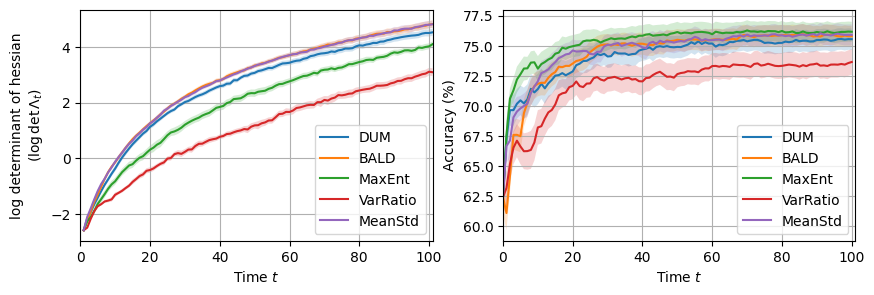

In [27]:
model_name = "MIRT"
plt.figure(figsize = (10,3))
for Algorithm_name in Algorithm_name_possible :
    
    Total_data = np.load(model_name + '_Tot_4_' + Algorithm_name + '.npy',allow_pickle=True)
    log_det_means, log_det_stds= np.mean(Total_data[0],axis=0), np.var(Total_data[0],axis=0)**0.5
    log_det_means, log_det_stds = np.array(log_det_means,dtype=float), np.array(log_det_stds,dtype=float)
    L2_means, L2_stds = np.mean(Total_data[1],axis=0), np.var(Total_data[1],axis=0)**0.5
    L2_means, L2_stds = np.array(L2_means,dtype=float), np.array(L2_stds,dtype=float)
    acc_means, acc_stds = np.mean(Total_data[2],axis=0), np.var(Total_data[2],axis=0)**0.5
    acc_means, acc_stds = np.array(acc_means,dtype=float), np.array(acc_stds,dtype=float)
    
    plt.subplot(1,2,1)
    times = [t for t in range(1,len(log_det_means)+1)]
    plt.plot(times, log_det_means, label = Algorithm_name)
    plt.fill_between(times, log_det_means - 0.2 * log_det_stds, log_det_means + 0.2 * log_det_stds, alpha = 0.2)
    plt.legend()
    plt.xlabel("Time " + r'$t$')
    plt.xlim([0,len(times)])
    plt.ylabel("log determinant of hessian\n" + r'$(\log\det\Lambda_t)$')
    plt.grid()
    
    plt.subplot(1,2,2)
    times = [t for t in range(len(acc_means))]
    plt.plot(times, 100*acc_means, label = Algorithm_name)
    plt.fill_between(times, 100*acc_means - 0.1 * 100*acc_stds, 100*acc_means + 0.1 * 100*acc_stds, alpha = 0.2)    
    plt.legend()
    plt.xlabel("Time " + r'$t$')
    plt.xlim([0,len(times)])
    plt.ylabel('Accuracy (%)')
    plt.grid()
    
plt.savefig(model_name+ ".pdf",bbox_inches='tight')